# Assignment 1.1
## Practical Deep Learning for Language Processing

11/17/2022

In [1]:
import torch
torch.set_printoptions(edgeitems=3)
import torchtext
data_dir = './'
fasttext = torchtext.vocab.FastText(language='en', cache=data_dir)
print('Loaded {} words'.format(len(fasttext.itos)))

/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/conda/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 2519370 words


# Task A
#### 1

In [2]:
import pandas as pd
# read the csv files
products = pd.read_csv("products.csv")
aisles = pd.read_csv("aisles.csv")

#### 2

In [3]:
# create a subset of hair care products
products_subset = products.loc[products["aisle_id"] == 22].copy()

In [4]:
# print the head of the subset
products_subset.head(5)

,product_id,product_name,aisle_id,department_id
50,51,Sa Extra Hold Mousse Hair Styling,22,11
54,55,Lasting Color Shampoo,22,11
213,214,Argan Oil of Morocco Renewing Weightless Heali...,22,11
307,308,Advanced Haircare Color Vibrancy Nourishing Sh...,22,11
371,372,Moisture Rich Sweet Orange & Argan Conditioner,22,11


#### 3

In [5]:
import re
def cleanupText(s):
    """
    Given a text, cleans. Feel free to add your own stuff.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«®\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    return s

In [6]:
# apply the provided cleanup function
products_subset["product_name"] = products_subset["product_name"].apply(cleanupText)

In [7]:
# print the head of the subset
products_subset.head(5)

,product_id,product_name,aisle_id,department_id
50,51,sa extra hold mousse hair styling,22,11
54,55,lasting color shampoo,22,11
213,214,argan oil of morocco renewing weightless heali...,22,11
307,308,advanced haircare color vibrancy nourishing sh...,22,11
371,372,moisture rich sweet orange and argan conditi...,22,11


#### 4

In [8]:
# import the nltk corpus
from nltk.corpus import stopwords
# split the words and remove if in stopwords
products_subset["product_name"] = products_subset["product_name"].apply(lambda x: " ".join([word for word in x.split() if word not in (stopwords.words("english"))]))

In [9]:
# print the head of the subset
products_subset.head(5)

,product_id,product_name,aisle_id,department_id
50,51,sa extra hold mousse hair styling,22,11
54,55,lasting color shampoo,22,11
213,214,argan oil morocco renewing weightless healing ...,22,11
307,308,advanced haircare color vibrancy nourishing sh...,22,11
371,372,moisture rich sweet orange argan conditioner,22,11


#### 5

In [10]:
# get the representations from the downloaded fasttext dictionary
products_subset["embedded"] = products_subset["product_name"].apply(lambda wordlist: [fasttext[x] for x in wordlist]) 

In [11]:
# print example for embedding
products_subset["embedded"].iloc[0][0][0:10]

tensor([ 0.0385, -0.1129, -0.1732, -0.0304,  0.1579, -0.0191,  0.0019, -0.1104,
        -0.0765,  0.1275])

#### 6

In [12]:
# a function to first stack the vectors into a matrix and then calculate element-wise means
def worker(x):
    return(torch.mean(torch.stack(x), axis = 0))
# calculate rowwise means
products_subset["representation"] = products_subset["embedded"].apply(worker)

In [13]:
# print example for representation
products_subset["representation"].iloc[0][0:10]

tensor([-0.0663, -0.0309, -0.0105, -0.0958, -0.0448, -0.0187,  0.0835, -0.1248,
        -0.0452,  0.0359])

#### 7

In [14]:
from sklearn.cluster import KMeans
# split the data to one column per representative feature
spread_data = products_subset["representation"].apply(pd.Series)
# calulate the clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(spread_data)

#### 8

Upon close inspection of the product names it appears to me that the two most dominant categories of products are conditioner and shampoo. To see if the clustering catches these classes, I plot the data: 

In [15]:
from sklearn.decomposition import PCA
# create a supplementary axis for the plot, creating an arbitrary feature with most variance
pca = PCA(n_components=1).fit(spread_data)

In [16]:
# creating a data frame for visualization
viz_subset = products_subset.copy()
# create a variable to distinguish shampoo, conditioner, hybrids and others
viz_subset.loc[(viz_subset["product_name"].str.contains("shampoo")), "class"] = "shampoo"
viz_subset.loc[(viz_subset["product_name"].str.contains("conditioner")), "class"] = "conditioner"
viz_subset.loc[(viz_subset["product_name"].str.contains("shampoo") &
                viz_subset["product_name"].str.contains("conditioner")), "class"] = "both"
viz_subset.loc[(~viz_subset["product_name"].str.contains("shampoo") &
                ~viz_subset["product_name"].str.contains("conditioner")), "class"] = "other"
# add the kmeans clusters to the data frame
viz_subset["cluster"] = kmeans.predict(spread_data)
# add the supplementary dimension to the data frame
viz_subset["plot_axis"] = pca.transform(spread_data)

<AxesSubplot: xlabel='plot_axis', ylabel='class'>

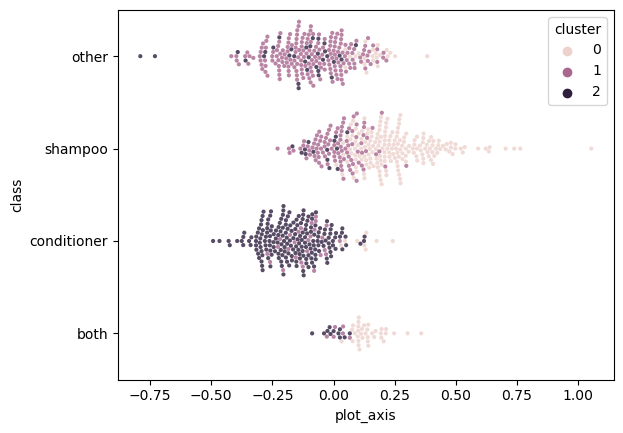

In [17]:
import seaborn as sns
# plot the data
sns.swarmplot(y = "class", x = "plot_axis", hue = "cluster", data = viz_subset, s = 3, alpha = .8)

We see that the clustering indeed catches the two main categories very well. Most conditioners land in cluster *2*, most shampoos in cluster *0* and most others in cluster *1*.

#### 9

Albeit the clustering is not perfect, I choose the labels `conditioner`, `shampoo`, `other` discussed above for the clusters

In [18]:
# set the variable cluster according to the clustering
products_subset["cluster"] = pd.Series(kmeans.predict(spread_data)).map({2: "conditioner",
                                                                         0: "shampoo",
                                                                         1: "other"}).values

In [19]:
# print an excerpt from the results
pd.concat([products_subset[["product_name", "cluster"]].head(5), products_subset[["product_name", "cluster"]].tail(5)])

,product_name,cluster
50,sa extra hold mousse hair styling,other
54,lasting color shampoo,shampoo
213,argan oil morocco renewing weightless healing ...,other
307,advanced haircare color vibrancy nourishing sh...,other
371,moisture rich sweet orange argan conditioner,conditioner
49528,soothing anti - dandruff shampoo,shampoo
49567,coconut hibiscus curl shine shampoo,shampoo
49624,golden wheat deep cleanse shampoo,other
49644,hair types pure clean finishing paste,other
49659,professionals sleek shampoo,shampoo


#### 10

/

# Task B

In [20]:
genres = ['action', 'adventure', 'comedy', 'drama', 'fantasy', 'horror', 'romance', 'thriller']
movies = ['The Hangover', 'Shutter Island', 'Fight Club', 'Jumanji', 'Narcos', 'The Matrix', 'Rush Hour', 'The Mummy', 'Iron Man', 'Silence of the Lambs', 'Batman Begins', 'Spider Man', 'The Hobbit', 'Troy', 'Jurassic Park', 'Scary Movie', 'Mission Impossible', 'Ted', 'Eat Pray Love', 'The Notebook', 'Love Actually', 'The Terminal', 'Crazy Stupid Love', 'Twilight', 'The Martian', 'Pursuit of Happyness']

In [21]:
# convert to pandas series for convenience
genres, movies = pd.Series(genres), pd.Series(movies)

In [22]:
# preprocess movies using the given function
movies = movies.apply(cleanupText)

In [23]:
# print an excerpt from the cleaned movie titles
movies.head(5)

0      the hangover
1    shutter island
2        fight club
3           jumanji
4            narcos
dtype: object

#### 1

In [24]:
# create a vector of work representations for the genres
genres_repr = [fasttext[x] for x in genres]

In [25]:
# print an example for a genre representation
genres_repr[0][0:10]

tensor([-0.0333, -0.0354, -0.2975,  0.3557, -0.1027,  0.2664, -0.2555, -0.2246,
         0.3623,  0.2451])

#### 2

In [26]:
# get indexes for multi-word movies
m_w_movies = movies.str.contains("\s")

In [27]:
# find representations for the single-worded titles
movies_repr = movies.loc[(~m_w_movies)].apply(lambda x: [fasttext[x]])

In [28]:
# print an example for a movie representation
movies_repr[3][0][0:10]

tensor([-0.1416, -0.0292, -0.6564,  0.4603, -0.3099,  0.2020,  0.0748,  0.2627,
        -0.0303,  0.1476])

#### 3

In [29]:
# create copy of movies for performing splits
movies_split = movies.copy()

In [30]:
# remove NLTK stopwords from the movie titles
movies_split.loc[(m_w_movies)] = \
    movies_split.loc[(m_w_movies)].\
        apply(lambda x: [word for word in x.split() if word not in (stopwords.words("english"))])

In [31]:
# print an excerpt from the stopword-ridden movie titles
movies_split.head(5)

0           [hangover]
1    [shutter, island]
2        [fight, club]
3              jumanji
4               narcos
dtype: object

In [32]:
# retrieve the word representations of the other movie tiles and
# add them to the list created in 2
movies_repr = \
    pd.concat([movies_repr, 
               movies_split.\
                   loc[(m_w_movies)].apply(lambda x: [fasttext[word] for word in x]).\
                       reindex(m_w_movies[m_w_movies].index)])

In [33]:
# print another example for a movie representation
movies_repr[1][0][0:10]

tensor([-0.0040,  0.3072,  0.2663,  0.0526, -0.3134, -0.0728, -0.3778,  0.1787,
        -0.1665, -0.1289])

#### 5

In [34]:
# define a function for the dot product
def cosine_sim(x, y):
    return((x @ y) / ((sum(x ** 2)) ** .5) * ((sum(y ** 2)) ** .5))

In [35]:
# print the classifications as a data frame
pd.DataFrame({"title": movies.values,
              "genre": movies_repr.sort_index().\
                  # calculate the cosine similarity between each word and genre
                  apply(lambda x: [torch.tensor([cosine_sim(z, y) for y in genres_repr]) for z in x]).\
                      # stack the similarities and calculate genre-wise means
                      apply(torch.stack).apply(torch.mean, axis = -2).\
                          # get the element with the highest similarity and map it to its genre
                          apply(lambda x: x.argmax().item()).map(genres).values})

,title,genre
0,the hangover,comedy
1,shutter island,thriller
2,fight club,comedy
3,jumanji,adventure
4,narcos,thriller
5,the matrix,fantasy
6,rush hour,thriller
7,the mummy,horror
8,iron man,comedy
9,silence of the lambs,thriller
